In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

# Updated imports for new modular pipeline
from xasdenoise.xas_data import data_io, visualization
from xasdenoise.denoising_methods.denoisers import RegularDenoiser  # Updated path
from xasdenoise.denoising_pipeline import PipelineConfig, DenoisingPipeline  # New modular pipeline

# Set global font size for all plots
plt.rcParams['figure.dpi'] = 120
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 18})  # Update the default font size for all text
plt.rcParams.update({'axes.titlesize': 18})  # Update the default font size for axes titles
plt.rcParams.update({'axes.labelsize': 18})  # Update the default font size for axes labels
plt.rcParams.update({'xtick.labelsize': 18})  # Update the default font size for x tick labels
plt.rcParams.update({'ytick.labelsize': 18})  # Update the default font size for y tick labels

# Load an example dataset
Either load the basic arrays from the csv file. Also we can load the previously created Spectrum object which contains various pre-computed arrays and values. 

Loaded NiMOF74 spectrum.
Loaded 1 spectra from ./data/time_resolved_spectra.h5


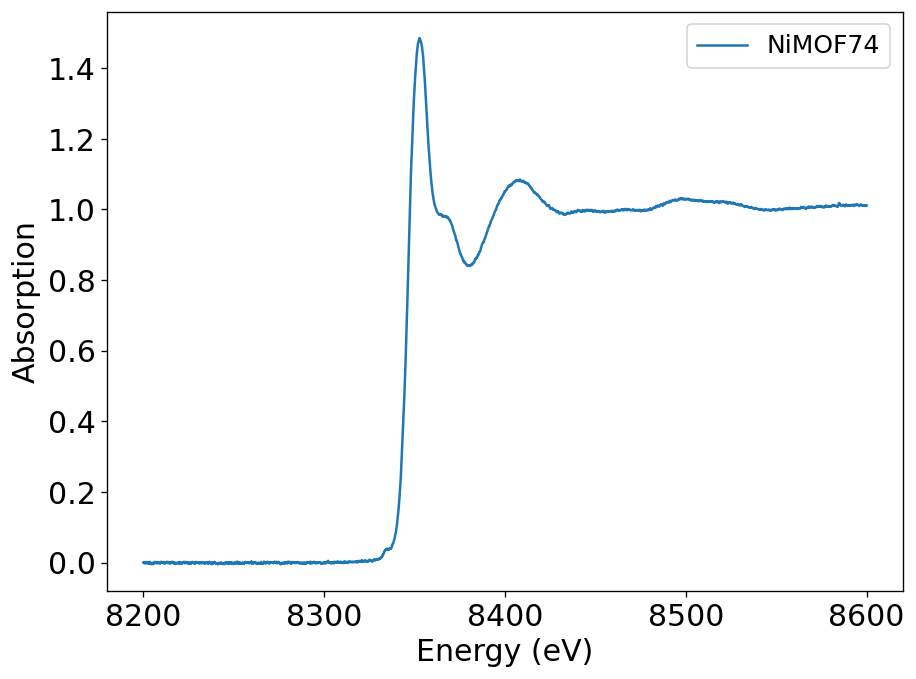

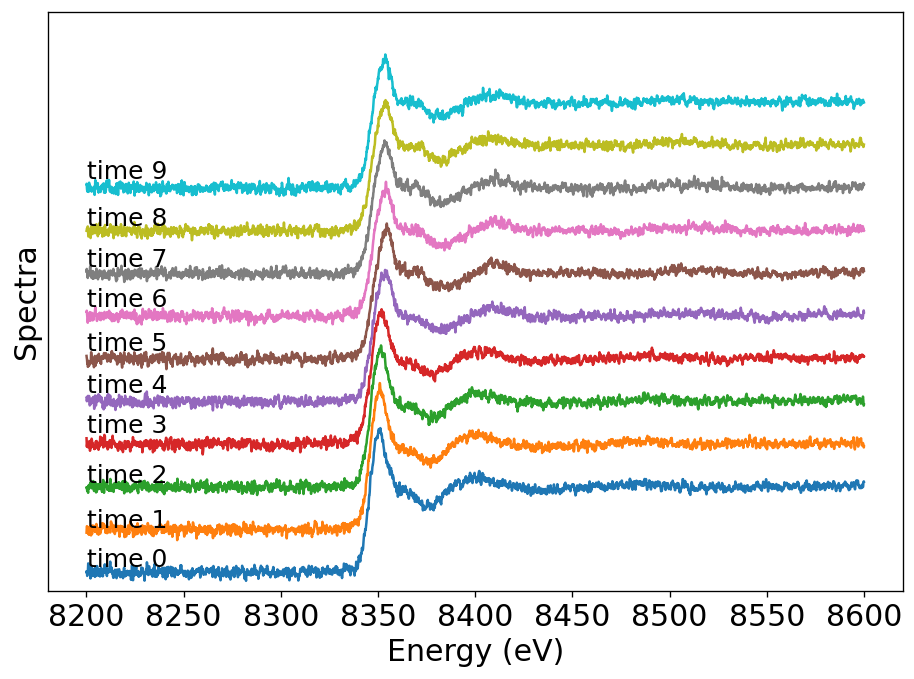

In [2]:
spectrum0 = data_io.load_spectra_from_h5('./data/time_resolved_spectra.h5')

# Visualize
visualization.plot_spectrum(spectrum0, time_averaged=True)
visualization.plot_spectrum_time_instances(spectrum0,vertical_displacement_offset=.5, time_instance_number=10)

# Time resolved data denoising using a RegularDenoiser
Depending on the method being used, the RegularDenoiser will either loop over each time instance and denoise it separately (e.g., butterworth filter, gaussian filter etc.). However there are also methods capable of taking multiple time instances into accout. A common approach is to use principle compoenent analysis (PCA) to separate signal components form the noise. Other approaches involve 2D filters, which can have anisotropic window sizes along energy and time axes. All of these methods are illustrated here.

In [3]:
def simple_denoising(spectrum_obj, denoising_method='butterworth', denoiser_params=None):
    """
    Simple denoising using the denoising pipeline.
    
    Returns:
        tuple: (denoised_spectrum, error_estimates, noise_estimates)
    """
    # Create pipeline configuration
    config = PipelineConfig(
        verbose=0,
        data_baseline_removal='step',  # Optional: remove baseline
        input_warping_method='kspace', # 'kspace', 'smoothness' or 'kspace_exafs_smoothness_xanes'
        warping_interpolation_method='downsample'  # Interpolate onto a uniform grid for warping
    )
    
    # Create denoiser
    denoiser = RegularDenoiser(denoising_method)
    if denoiser_params is not None:
        denoiser.params = denoiser_params
        
    # Create and run pipeline with method chaining
    pipeline = DenoisingPipeline(config)
    pipeline.load_data(spectrum_obj).process(denoiser)
    
    # Get results
    y_denoised, y_error, y_noise = pipeline.get_results()
    
    # Plot results
    visualization.plot_spectrum_time_instances(spectrum_obj,vertical_displacement_offset=.5, time_instance_number=10)
    spectrum_obj.spectrum = y_denoised
    visualization.plot_spectrum_time_instances(spectrum_obj, vertical_displacement_offset=.1, time_instance_number=10)
    return y_denoised, y_error, y_noise

### 1D denoising examples

Denoising using method butterworth, with the following parameters
  order: 3
  cutoff: 0.025


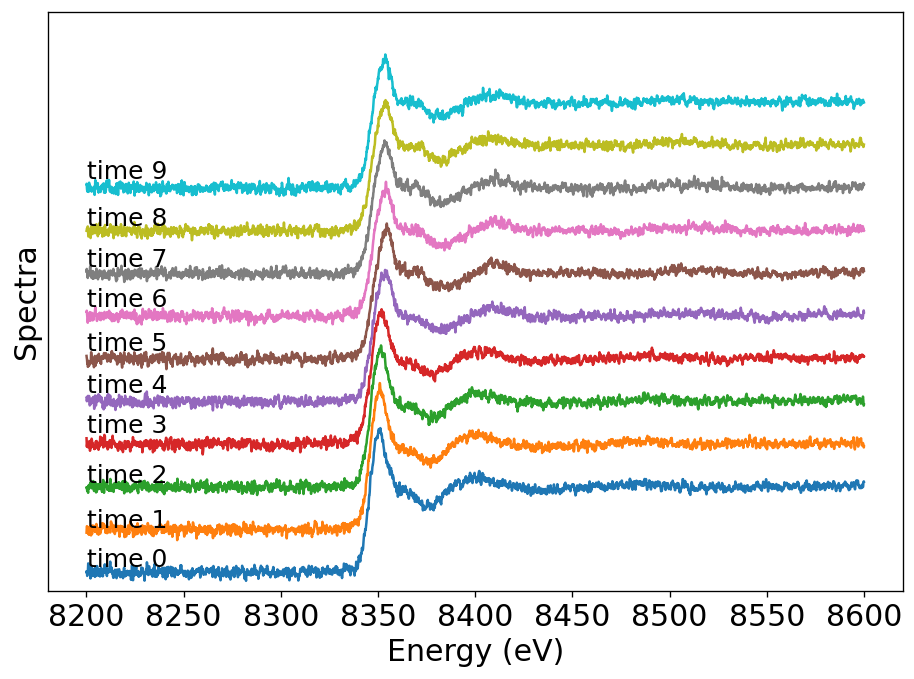

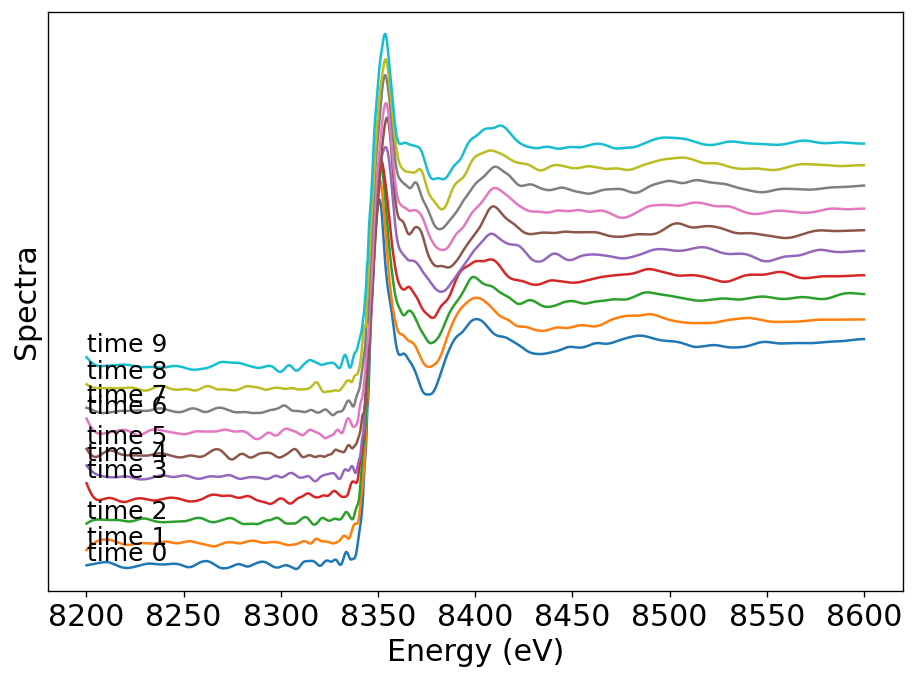

In [4]:
denoiser_params = {}
denoiser_params['cutoff'] = 0.02
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj, denoising_method='butterworth', denoiser_params=denoiser_params)

### 2D denoising examples
Here the neighboring (or all) time instances are taken into account to improve denoising quality.

Denoising using method pca, with the following parameters
  modes: 1


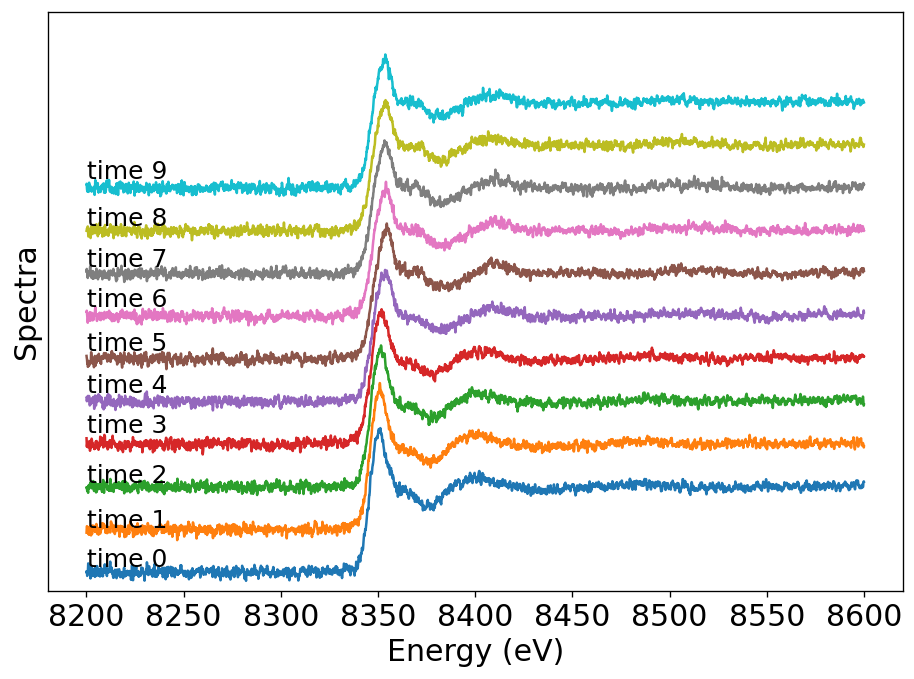

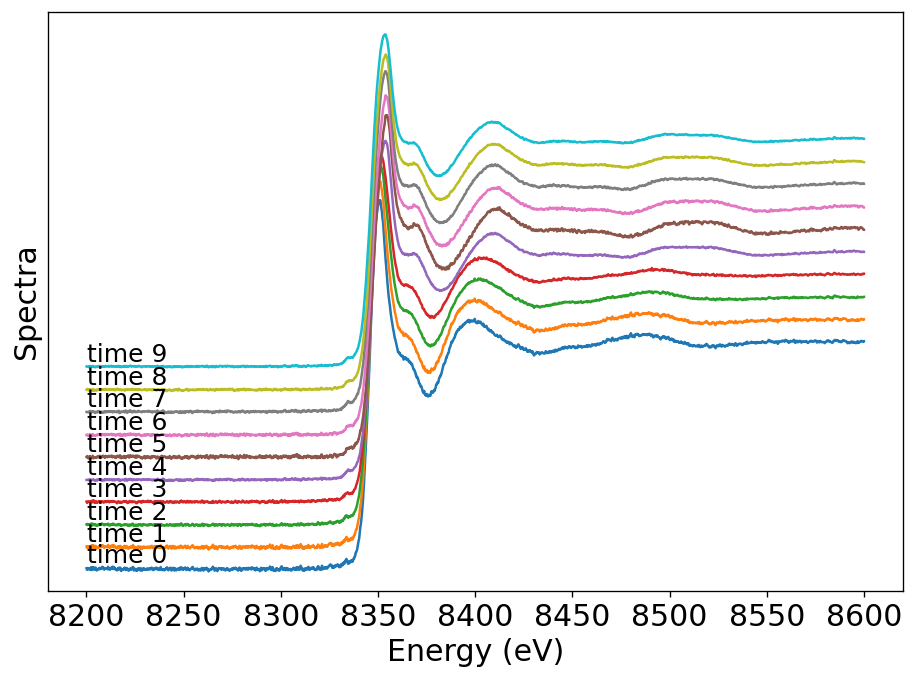

In [5]:
denoiser_params = {}
denoiser_params['modes'] = 3
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj, denoising_method='pca', denoiser_params=denoiser_params)

In [ ]:
denoiser_params = {}
denoiser_params['weight'] = .5
denoiser_params['eps'] = 2.0e-6
denoiser_params['max_iter'] = 500
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj, denoising_method='total_variation_2d', denoiser_params=denoiser_params)

Denoising using method total_variation_2d, with the following parameters
  weight: 1
  max_iter: 200
  eps: 2e-06


Denoising using method non_local_means_2d, with the following parameters
  patch_size: 11
  search_size: 11
  h: 0.1


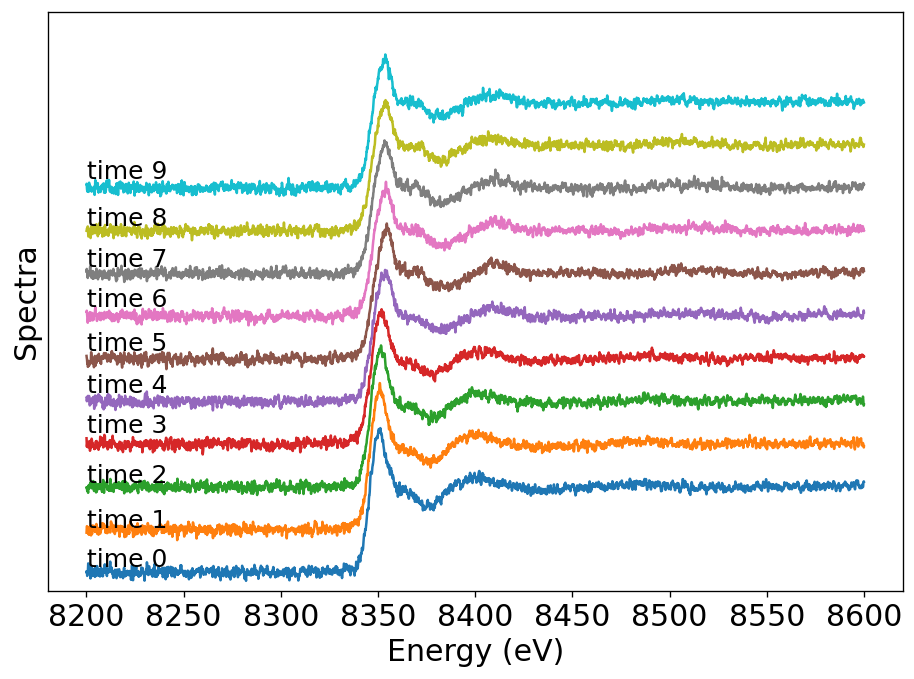

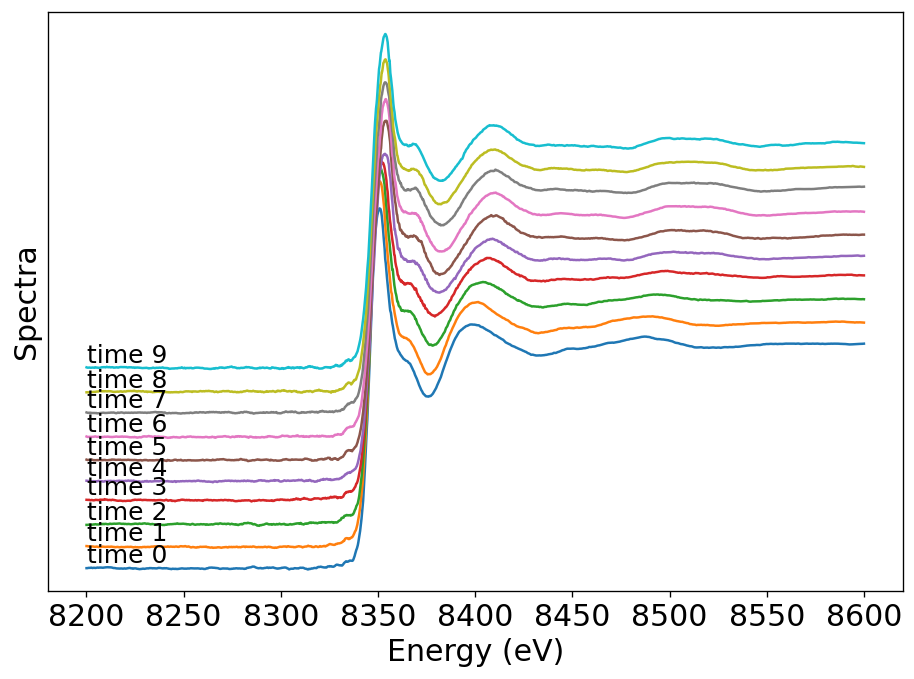

In [ ]:
denoiser_params = {}
denoiser_params['search_size'] = 21
spectrum_obj = spectrum0.copy()  # Copy to avoid modifying original
y_denoised, y_error, y_noise = simple_denoising(spectrum_obj, denoising_method='non_local_means_2d', denoiser_params=denoiser_params)